# OPENTIS
## An Example with Alanine

Import Modules

In [1]:
import numpy as np
import mdtraj as md
import pandas as pd
import time
import sys, os
 
# in principle, all of these imports should be simplified once this is a package
from openpathsampling.collectivevariable import CV_Function, CV_Volume, CV_MD_Function
from openpathsampling.snapshot import Snapshot
from openpathsampling.volume import CVRangeVolumePeriodic, VolumeFactory as vf
from openpathsampling.pathmover import PathMoverFactory as mf
from openpathsampling.ensemble import EnsembleFactory as ef
from openpathsampling.ensemble import (LengthEnsemble, SequentialEnsemble, AllOutXEnsemble,
                      AllInXEnsemble, PartInXEnsemble, PartOutXEnsemble)
from openpathsampling.storage import Storage
from openpathsampling.trajectory import Trajectory
from openpathsampling.pathsimulator import Bootstrapping
from openpathsampling.shooting import UniformSelector
from openpathsampling.pathmover import PathMover, SampleGeneratingMover
import simtk.unit as u

from openpathsampling.openmm_engine import OpenMMEngine

from openpathsampling.storage import Storage
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

import openpathsampling as paths

Radians to Degree conversion

In [2]:
degrees = 180/3.14159 # psi reports in radians; I think in degrees

Create an AlanineOpenMMSimulator for demonstration purposes

### Set simulation options and create a simulator object

In [3]:
options = {
            'temperature' : 300.0 * u.kelvin,
            'collision_rate' : 1.0 / u.picoseconds,
            'timestep' : 2.0 * u.femtoseconds,
            'nsteps_per_frame' : 10,
            'n_frames_max' : 5000,
            'start_time' : time.time(),
            'fn_initial_pdb' : "../data/Alanine_solvated.pdb",
            'platform' : 'fastest',
            'solute_indices' : range(22),
            'forcefield_solute' : 'amber96.xml',
            'forcefield_solvent' : 'tip3p.xml'
           }

In [4]:
engine = OpenMMEngine.auto(
                filename="trajectory.nc",
                template="../data/Alanine_solvated.pdb",
                options=options,
                mode='create'
                )

<type 'str'> transitions_uid
<type 'str'> transitions_name
<type 'str'> transitions_json
<type 'str'> pathmovechanges_details
<type 'str'> pathmovechanges_mover
<type 'str'> pathmovechanges_cls
<type 'str'> pathmovechanges_subchanges
<type 'str'> pathmovechanges_samples
<type 'str'> engines_uid
<type 'str'> engines_name
<type 'str'> engines_json
<type 'str'> shootingpoints_json
<type 'str'> topologies_uid
<type 'str'> topologies_name
<type 'str'> topologies_json
<type 'str'> pathsimulators_uid
<type 'str'> pathsimulators_name
<type 'str'> pathsimulators_json
<type 'str'> trajectories_json
<type 'str'> trajectories_snapshots
<type 'str'> cvs_uid
<type 'str'> cvs_name
<type 'str'> cvs_json
<type 'str'> snapshots_configuration
<type 'str'> snapshots_momentum
<type 'str'> snapshots_momentum_reversed
<type 'str'> snapshots_reversed_idx
<type 'str'> pathmovers_uid
<type 'str'> pathmovers_name
<type 'str'> pathmovers_json
<type 'str'> steps_change
<type 'str'> steps_active
<type 'str'> steps_

And save the storage in a separate variable for convenience

In [5]:
a = u.Quantity(1.0, u.nanometer)

In [6]:
a

Quantity(value=1.0, unit=nanometer)

In [7]:
storage = engine.storage
paths.EngineGeneratingMover.engine = engine

Equilibrate

In [8]:
engine.current_snapshot = engine.template
engine.equilibrate(5)
engine.initialized = True

Save equilibrated snapshot with index 0

In [9]:
storage.save(engine.current_snapshot);

snapshots_configuration 2  :  <openpathsampling.snapshot.Configuration object at 0x10fa8f910> False
configurations_coordinates 1  :  [[-0.34677196  0.1590445   0.10582972]
 [-0.30411649  0.05907273  0.09763598]
 [-0.33632684  0.01478958  0.00338912]
 ..., 
 [-0.92953336  1.19636369  1.1878978 ]
 [-0.93842602  1.25429213  1.2635783 ]
 [-0.87183142  1.12618983  1.21803808]] nm True
configurations_potential_energy 1  :  -24504.7704161 kJ/mol True
configurations_box_vectors 1  :  [[ 2.60630012  0.          0.        ]
 [ 0.          2.60630012  0.        ]
 [ 0.          0.          2.60630012]] nm True
snapshots_momentum 2  :  <openpathsampling.snapshot.Momentum object at 0x10fa8f990> False
momenta_velocities (1, slice(None, None, None), slice(None, None, None))  :  [[  6.77651027e-03  -7.38692982e-03   2.52874438e-02]
 [  1.16127229e-03  -7.71911023e-03   1.08194436e-04]
 [  1.61183089e-01   2.79944479e-01  -1.89744383e-01]
 ..., 
 [  1.47522520e-02  -5.62047772e-02   9.35279578e-02]
 [ 

### Order Parameters

this generates an order parameter (callable) object named psi (so if we call `psi(trajectory)` we get a list of the values of psi for each frame in the trajectory). This particular order parameter uses mdtraj's compute_dihedrals function, with the atoms in psi_atoms

In [10]:
psi_atoms = [6,8,14,16]
psi = CV_MD_Function("psi", md.compute_dihedrals,
                  indices=[psi_atoms])

phi_atoms = [4,6,8,14]
phi = CV_MD_Function("phi", md.compute_dihedrals,
                  indices=[phi_atoms])

In [11]:
storage.save([psi, phi]);

<type 'str'> cvs_0_psi_value
<type 'str'> cvs_1_phi_value


In [12]:
cv = paths.CV_Function('myfnc', lambda x : (x.xyz[0][0], x.xyz[1][0] ), store_cache=False)

In [13]:
cv2 = paths.CV_Function('my1', lambda x, cv : cv(x)[0], cv=cv, store_cache=False)
cv3 = paths.CV_Function('my1', lambda x, cv : cv(x)[1], cv=cv, store_cache=True)

In [14]:
storage.save([cv2,cv3])

<type 'str'> cvs_4_my1_value


[True, True]

In [15]:
cv3([engine.template, engine.template])

[-0.3044, -0.3044]

In [16]:
l = lambda x : (x.xyz[0][0], x.xyz[1][0] )
l(engine.template)

(-0.34729999, -0.3044)

In [17]:
cv3.sync(storage)

In [18]:
storage.sync()

In [19]:
cv3.func_dict.fnc_uses_lists

False

### Volumes

This creates two states using a one-dimensional order parameter (called _Lambda_ in TIS terminology). A snapshot is in the State as long as the order parameter is with specific bounds. 

In [20]:
stateA = CVRangeVolumePeriodic(
    collectivevariable=psi, 
    lambda_min=-120.0/degrees, 
    lambda_max=-30.0/degrees, 
    period_min=-180.0/degrees, 
    period_max=+180.0/degrees
)
stateB = CVRangeVolumePeriodic(psi, 100/degrees, 180/degrees, -180.0/degrees, +180.0/degrees)

Now do the same for a set of lambda ranges to produce nested volumes.

In [21]:
minima = map((1.0 / degrees).__mul__,
             [-125, -135, -140, -142.5, -145.0, -147.0, -150.0])

maxima = map((1.0 / degrees).__mul__,
             [-25.0, -21.0, -18.5, -17.0, -15.0, -10.0, 0.0])

volume_set = vf.CVRangeVolumePeriodicSet(psi, minima, maxima, -180.0/degrees, +180.0/degrees)

### Ensembles

Now do this automatically for all ensembles

In [22]:
interface0 = volume_set[0]
interface_set = ef.TISEnsembleSet(stateA, stateA | stateB, volume_set, psi)
for no, interface in enumerate(interface_set):
    # Give each interface a name
    interface.name = 'Interface '+str(no)
    # And save all of these
    storage.ensembles.save(interface)

And create a special ensemble, that will create a first trajectory in the innermost TIS ensemble independent from where we start

The idea is to describe a trajectory type by a sequence of positions. First can be outside of stateA or not, then be inside stateA, etc...

In [23]:
first_traj_ensemble = SequentialEnsemble([
    AllOutXEnsemble(stateA) | LengthEnsemble(0),
    AllInXEnsemble(stateA),
    (AllOutXEnsemble(stateA) & AllInXEnsemble(interface0)) | LengthEnsemble(0),
    AllInXEnsemble(interface0) | LengthEnsemble(0),
    AllOutXEnsemble(interface0),
    AllOutXEnsemble(stateA) | LengthEnsemble(0),
    AllInXEnsemble(stateA) & LengthEnsemble(1)
])

In [24]:
platform = engine.simulation.context.getPlatform()
print platform.getName()

CUDA


### start path generation

so lets try and see if we can generate a first path

load the initial snapshot (although we still have it) and generate using the Alanine simulator. The second option specifies a function : trajectory -> bool that keeps the simulation running as long as it is true. Our goal was to generate a path that belongs to a specific ensemble, so we use `forward` to determine if it makes sense to keep running or if the result cannot belong to the ensemble anymore.

In [25]:
snapshot = storage.load(Snapshot, 0)
total_path = engine.generate(
    snapshot= snapshot, 
    running = [first_traj_ensemble.can_append]
)

Show the length

In [26]:
print "Total trajectory length: ", len(total_path)

Total trajectory length:  53


And save the trajetory completely

In [27]:
storage.save(total_path);

snapshots_configuration 4  :  <openpathsampling.snapshot.Configuration object at 0x10fa7a090> False
configurations_coordinates 2  :  [[-0.34570605  0.1617887   0.10396148]
 [-0.30428618  0.06122089  0.09678566]
 [-0.33457258  0.01502427  0.00281967]
 ..., 
 [-0.92997748  1.19580281  1.18808496]
 [-0.93519998  1.25387013  1.26400101]
 [-0.87613368  1.12240195  1.21767342]] nm True
configurations_potential_energy 2  :  -24512.6888416 kJ/mol True
configurations_box_vectors 2  :  [[ 2.60630012  0.          0.        ]
 [ 0.          2.60630012  0.        ]
 [ 0.          0.          2.60630012]] nm True
snapshots_momentum 4  :  <openpathsampling.snapshot.Momentum object at 0x10fa7a4d0> False
momenta_velocities (2, slice(None, None, None), slice(None, None, None))  :  [[-0.0138815   0.17435874 -0.28213269]
 [-0.0918695   0.12022073  0.02644376]
 [ 0.14402083  0.17720635 -0.07760253]
 ..., 
 [-0.04416059 -0.07233946  0.10113616]
 [ 0.09314242 -0.28333372  0.27196875]
 [-0.24601096 -0.3031658

Split the trajectory into parts that belong to the TIS ensemble (not the one we generated)

In [28]:
interface0_ensemble = interface_set[0]
segments = interface0_ensemble.split(total_path)

print "Traj in first_traj_ensemble? (should be)", 
print first_traj_ensemble(total_path)

print "Traj in TIS ensemble? (probably not)", 
print interface0_ensemble(total_path)


print "Number of segments in TIS ensemble: ", len(segments)
if len(segments):
    print "Length of each segment:"
    for i in range(len(segments)):
        print "  seg[{0}]: {1}".format(i, len(segments[i]))

Traj in first_traj_ensemble? (should be) True
Traj in TIS ensemble? (probably not) False
Number of segments in TIS ensemble:  1
Length of each segment:
  seg[0]: 29


Show some results and check if this worked

In [29]:
data = []
for frame in total_path:
    data.append((phi(frame)[0]*degrees, psi(frame)[0]*degrees, stateA(frame), interface0(frame), stateB(frame), first_traj_ensemble.can_append(total_path[slice(0,total_path.index(frame)+1)])))
    
dataframe = pd.DataFrame(data, columns=['phi', 'psi', 'stateA', 'interface0', 'stateB', 'appendable'])
dataframe[[0,1,2,3,4,5]].ix[[0,1,2,len(dataframe)-3,len(dataframe)-2,len(dataframe)-1]]

,phi,psi,stateA,interface0,stateB,appendable
0,-80.208523,-10.277041,[False],[False],[False],True
1,-83.805959,-10.504156,[False],[False],[False],True
2,-79.595977,-13.894038,[False],[False],[False],True
50,-52.118834,-26.100277,[False],[True],[False],True
51,-49.016392,-29.254565,[False],[True],[False],True
52,-64.677971,-30.918623,[True],[True],[False],False


In [30]:
print "Do our segments satisfy the ensemble?",
for seg in segments:
    print interface0_ensemble(seg),

Do our segments satisfy the ensemble? True


In [31]:
data = []
for frame in segments[0]:
    data.append((phi(frame)[0]*degrees, psi(frame)[0]*degrees, stateA(frame), interface0(frame), stateB(frame), first_traj_ensemble.can_append(total_path[slice(0,total_path.index(frame)+1)])))
    
dataframe = pd.DataFrame(data, columns=['phi', 'psi', 'stateA', 'interface0', 'stateB', 'appendable'])
dataframe[[0,1,2,3,4,5]]

,phi,psi,stateA,interface0,stateB,appendable
0,-87.332225,-30.882535,[True],[True],[False],True
1,-90.292274,-28.131182,[False],[True],[False],True
2,-86.543624,-29.869959,[False],[True],[False],True
3,-83.440653,-27.604716,[False],[True],[False],True
4,-86.422129,-19.061947,[False],[False],[False],True
5,-85.253653,-18.660656,[False],[False],[False],True
6,-86.021278,-16.710005,[False],[False],[False],True
7,-78.097999,-19.124624,[False],[False],[False],True
8,-75.947888,-17.971983,[False],[False],[False],True
9,-70.337689,-17.696600,[False],[False],[False],True


### Bootstrapping

Run a bootstrapping (not TIS) simulation that shoots from an ensemble until the next interface is reached then switch to the next ensemble to drive the system out of stateA

In [32]:
mover_set = mf.OneWayShootingSet(UniformSelector(), interface_set)

In [33]:
bootstrap = Bootstrapping(storage=storage,
                          engine=engine,
                          ensembles=interface_set,
                          movers=mover_set,
                          trajectory=segments[0])

samples_trajectory 0  :  Trajectory[29] True
samples_ensemble 0  :  [
(
  x[t] in {x|(psi(x) - -3.14159) % 6.28318 + -3.14159 in [-2.09439333333, -0.523598333333]} for all t
)
and
(
  len(x) = 1
),
(
  x[t] in (not ({x|(psi(x) - -3.14159) % 6.28318 + -3.14159 in [-2.09439333333, -0.523598333333]} or ({x|(psi(x) - -3.14159) % 6.28318 + -3.14159 in [-2.09439333333, -0.523598333333]} or {x|(psi(x) - -3.14159) % 6.28318 + -3.14159 in [-3.14159, -3.14159] union [1.74532777778, 3.14159]}))) for all t
)
and
(
  exists t such that x[t] in {x|(psi(x) - -3.14159) % 6.28318 + -3.14159 in [-3.14159, -2.18165972222] union [-0.436331944444, 3.14159]}
),
(
  x[t] in ({x|(psi(x) - -3.14159) % 6.28318 + -3.14159 in [-2.09439333333, -0.523598333333]} or ({x|(psi(x) - -3.14159) % 6.28318 + -3.14159 in [-2.09439333333, -0.523598333333]} or {x|(psi(x) - -3.14159) % 6.28318 + -3.14159 in [-3.14159, -3.14159] union [1.74532777778, 3.14159]})) for all t
)
and
(
  len(x) = 1
)
] False
samples_replica 0  :  0 F

Run Bootstrapping with at most 50 attempts per ensemble

In [34]:
bootstrap.run(50)

DONE! Completed Bootstrapping cycle step 7 in ensemble 7/7 .



Save all computed phi/psi values which depends on whether they have been needed before

In [35]:
storage.collectivevariables.sync(psi);
storage.collectivevariables.sync(phi);

Create an collectivevariable from a volume which is just 1 or 0 and can thus be stored for later analysis

In [36]:
op_inA = CV_Volume('StateA', stateA)
op_inA.uid = 'StateA'
op_inB = CV_Volume('StateB', stateB)
op_inB.uid = 'StateB'
op_notinAorB = CV_Volume('StateX', ~ (stateA | stateB))
op_notinAorB.uid = 'StateX'

Compute the collectivevariable for all snapshots

In [37]:
#op_inA(storage.snapshots)
#op_inB(storage.snapshots)
#op_notinAorB(storage.snapshots);

Save the new collectivevariables

In [38]:
storage.save([op_inA, op_inB, op_notinAorB]);
storage.cvs.sync()
storage.sync()

<type 'str'> cvs_5_StateA_value
<type 'str'> cvs_6_StateB_value
<type 'str'> cvs_7_StateX_value


In [39]:
storage.close()

In [40]:
import openpathsampling as paths
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG
import mdtraj

In [41]:
storage = paths.storage.Storage('trajectory.nc', mode='r')

## Visualization

Create a PathTree generator

In [42]:
tree = PathTreeBuilder(storage)

Change the settings to show rejected pathways, mark OrderParaemters `stateA` and `stateX`, and show the 'psi' value as text inside of the boxes

In [43]:
tree.rejected = False
tree.states = [ ('orange',storage.cvs[2])]
# Some ideas for collectivevariables to visualize
tree.op = lambda snap : 'B' if snap.reversed else 'F'
tree.op = lambda snap : int(psi(snap)[0]/3.1415926 * 180)
tree.op = lambda snap : snap.configuration.idx[storage]
samps = tree.construct_heritage(storage.samples[len(storage.samples) - 1])
tree.from_samples(samps)
#for sset in storage.samplesets:
#    print sset.movepath
    
#for s in samps:
#    print (s, s.ensemble.idx[storage], s.replica, len(tree.construct_heritage(s)), s.mover.__class__.__name__)

Render the tree

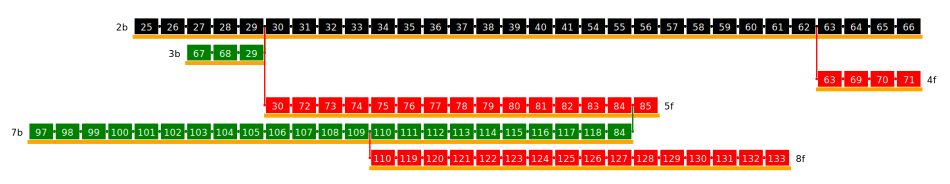

In [44]:
view = tree.renderer
view.zoom = 1.1
view.scale_y = 24
view.scale_x = 24
view.font_size = 0.35
SVG(view.to_svg())

An alternate view which is similar to the standard way of plotting

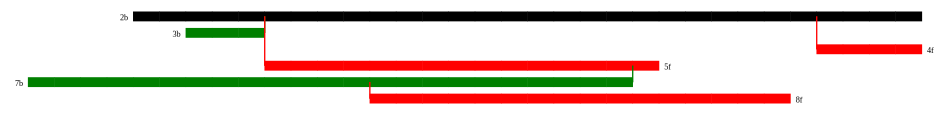

In [45]:
tree.rejected = False
tree.states = []
tree.op = None
tree.from_samples(samps)
view = tree.renderer
view.zoom = 1.1
view.horizontal_gap = -0.01
view.scale_y = 15
view.scale_x = 24
view.font_size = 0.5
view.font_family = 'Times'
SVG(view.to_svg())

### Phi/Psi Plots

In [46]:
# Imports for plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.legend_handler import HandlerLine2D

Make sure that all phi/psi values have been computed!

In [47]:
psi = storage.cvs[0]
phi = storage.cvs[1]

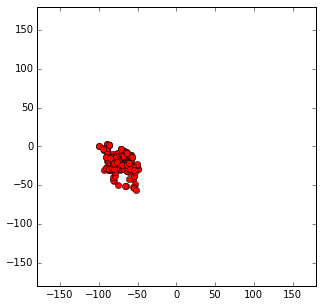

In [48]:
plt.figure(figsize=(5, 5))

for traj in storage.trajectories.iterator():
    phi_angles = degrees * np.array(phi(traj)).flatten()
    psi_angles = degrees * np.array(psi(traj)).flatten()
    plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    
plt.xlim(-180, 180);
plt.ylim(-180, 180);

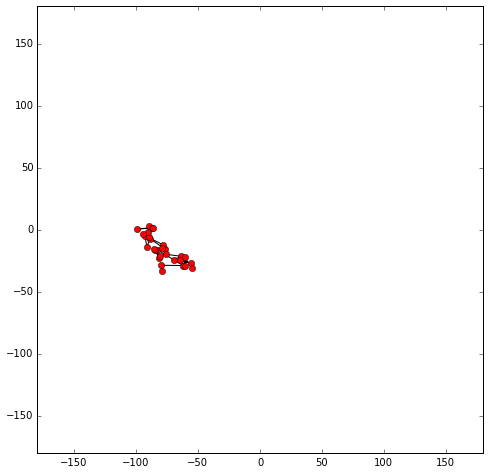

In [49]:
plt.figure(figsize=(8, 8))

traj = storage.trajectories.last()
phi_angles = degrees * np.array(phi(traj)).flatten()
psi_angles = degrees * np.array(psi(traj)).flatten()
plt.plot(phi_angles, psi_angles, 'k-', linewidth=1);

op_notinAorB = storage.cvs[4]

for snapshot in traj:
    phi_angles = degrees * np.array(phi(snapshot)).flatten()
    psi_angles = degrees * np.array(psi(snapshot)).flatten()
    if op_notinAorB(snapshot):
        plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    else:
        plt.plot(phi_angles, psi_angles, 'bo', linewidth=1);
        
plt.xlim(-180, 180);
plt.ylim(-180, 180);

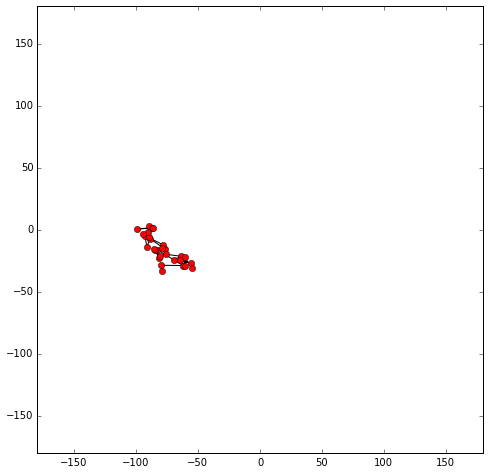

In [50]:
plt.figure(figsize=(8, 8))

traj = storage.samples.last().trajectory
phi_angles = degrees * np.array(phi(traj)).flatten()
psi_angles = degrees * np.array(psi(traj)).flatten()
plt.plot(phi_angles, psi_angles, 'k-', linewidth=1);


#for snapshot in simulator.storage.snapshot.iterator():
for snapshot in traj:
    phi_angles = degrees * np.array(phi(snapshot)).flatten()
    psi_angles = degrees * np.array(psi(snapshot)).flatten()
    if op_notinAorB(snapshot):
        plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    else:
        plt.plot(phi_angles, psi_angles, 'bo', linewidth=1);
        
plt.xlim(-180, 180);
plt.ylim(-180, 180);